In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [35]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')

# Columns to drop
# columns = [
#     'date_forecast',
#     'super_cooled_liquid_water:kgm2',
#     'air_density_2m:kgm3',
#     'snow_water:kgm2',
#     'precip_5min:mm',
#     'precip_type_5min:idx',
#     'rain_water:kgm2',
#     'snow_melt_10min:mm',
#     'dew_or_rime:idx',
#     'snow_depth:cm',
#     'prob_rime:p',
#     'is_day:idx',
#     'is_in_shadow:idx',
#     'visibility:m',
#     'relative_humidity_1000hPa:p',
#     'temp_dewpoint_diff'
# ]

# Drop columns
# obs_A = obs_A.drop(columns=columns)
# obs_B = obs_B.drop(columns=columns)
# obs_C = obs_C.drop(columns=columns)
# est_A = est_A.drop(columns=columns)
# est_B = est_B.drop(columns=columns)
# est_C = est_C.drop(columns=columns)
# test_A = test_A.drop(columns=columns)
# test_B = test_B.drop(columns=columns)
# test_C = test_C.drop(columns=columns)

In [36]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

# Data splits for submissions
# X_A = A.drop(columns='pv_measurement')
# y_A = A['pv_measurement']
# X_B = B.drop(columns='pv_measurement')
# y_B = B['pv_measurement']
# X_C = C.drop(columns='pv_measurement')
# y_C = C['pv_measurement']

# Data splits for testing
train_A, test_A = train_test_split(A, test_size=0.2, shuffle=True, random_state=42)
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_test_A = test_A.drop(columns='pv_measurement')
y_test_A = test_A['pv_measurement']

train_B, test_B = train_test_split(B, test_size=0.2, shuffle=True, random_state=42)
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_test_B = test_B.drop(columns='pv_measurement')
y_test_B = test_B['pv_measurement']

train_C, test_C = train_test_split(C, test_size=0.2, shuffle=True, random_state=42)
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_test_C = test_C.drop(columns='pv_measurement')
y_test_C = test_C['pv_measurement']



In [37]:
# Inspect data
X_train_A.shape

(27268, 6)

In [38]:
# Store evaluation results in a dictionary
evals_result_A = {}
evals_result_B = {}
evals_result_C = {}

# Initalize the models
parameters_A = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 1000, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_A, y_train_A), (X_test_A, y_test_A)]
}

parameters_B = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 1000, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_B, y_train_B), (X_test_B, y_test_B)]
}

parameters_C = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 1000, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_C, y_train_C), (X_test_C, y_test_C)]
}


tscv = TimeSeriesSplit(n_splits=10)
model_A = xgb.XGBRegressor(**parameters_A)
model_B = xgb.XGBRegressor(**parameters_B)
model_C = xgb.XGBRegressor(**parameters_C)

In [39]:
# Fit the models, verbose=False
model_A.fit(
    X=X_train_A, y=y_train_A,
    eval_set=[(X_train_A, y_train_A), (X_test_A, y_test_A)],
    eval_metric='mae',
    verbose=False
)

model_B.fit(
    X=X_train_B, y=y_train_B,
    eval_set=[(X_train_B, y_train_B), (X_test_B, y_test_B)],
    eval_metric='mae',
    verbose=False
)

model_C.fit(
    X=X_train_C, y=y_train_C,
    eval_set=[(X_train_C, y_train_C), (X_test_C, y_test_C)],
    eval_metric='mae',
    verbose=False
)

[11:45:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[11:45:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[11:45:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             eval_set=[(          PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5
12829  0.951658  2.101917 -1.540939  0.740345  0.031043  3.063546
12333 -3.745442 -2.804428 -1.884023  0.074171 -0.090373 -0.691463
8...
             feature_types=None, gamma=0.8, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.008, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [40]:
# Evaluate
print('MAE A:', mean_absolute_error(y_test_A, model_A.predict(X_test_A)))
print('MAE B:', mean_absolute_error(y_test_B, model_B.predict(X_test_B)))
print('MAE C:', mean_absolute_error(y_test_C, model_C.predict(X_test_C)))

# Total MAE for all three locations
print('Total MAE:', (mean_absolute_error(y_test_A, model_A.predict(X_test_A)) + mean_absolute_error(y_test_B, model_B.predict(X_test_B)) + mean_absolute_error(y_test_C, model_C.predict(X_test_C)))/3)

# Experimental
# MAE A: 175.31433575204986
# MAE B: 29.518360638758928
# MAE C: 18.769847334058188

# Experimental (550 n_estimators, tree_depth=20, learning_rate=0.008)
# MAE A: 177.72908897234717
# MAE B: 29.957880946132395
# MAE C: 18.95235475388517

# Experimental (550 n_estimators, tree_depth=20, learning_rate=0.008)
# MAE A: 174.63028077803693
# MAE B: 28.223511381967697
# MAE C: 18.669229191717907

# Experimental (1000 n_estimators, tree_depth=20, learning_rate=0.008)
# MAE A: 170.91436941088756
# MAE B: 27.5586344734014
# MAE C: 18.400349358621824

# Experimental (1000 n_estimators, tree_depth=10, learning_rate=0.008)
# MAE A: 175.31433575204986
# MAE B: 29.518360638758928
# MAE C: 18.769847334058188

# Best score (1000 n_estimators)
# MAE A: 184.09197423906127
# MAE B: 36.461958305611105
# MAE C: 20.004682998658588

# Best score (550 n_estimators)
# MAE A: 185.15747412325072
# MAE B: 36.84486826484117
# MAE C: 20.101314642979574

MAE A: 222.90628655182195
MAE B: 34.345727968204386
MAE C: 30.09516089521119
Total MAE: 95.78239180507917


In [41]:
# Feature importance
feature_importances = model_C.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X_train_A.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

# Print feature importance
for i in range(feature_importances.shape[0]):
    print(f"{i} {feature_importances.iloc[i, 0]}: {feature_importances.iloc[i, 1]}")

0 PCA_0: 0.6886814832687378
1 PCA_4: 0.07217327505350113
2 PCA_5: 0.06563681364059448
3 PCA_1: 0.05975192040205002
4 PCA_3: 0.058785829693078995
5 PCA_2: 0.054970741271972656


In [42]:
# Create submission

# output_file = 'xgb_submission.csv'

# pred_A = model_A.predict(test_A)
# pred_B = model_B.predict(test_B)
# pred_C = model_C.predict(test_C)

# pred_A = np.clip(pred_A, 0, None)
# pred_B = np.clip(pred_B, 0, None)
# pred_C = np.clip(pred_C, 0, None)

# # Concatenate predictions
# predictions = np.concatenate([pred_A, pred_B, pred_C])

# # Create an id array
# ids = np.arange(0, len(predictions))

# # Create a DataFrame
# df = pd.DataFrame({
#     'id': ids,
#     'prediction': predictions
# })

# # Save to CSV
# df.to_csv(output_file, index=False)
# print(f"Submission saved to {output_file}")

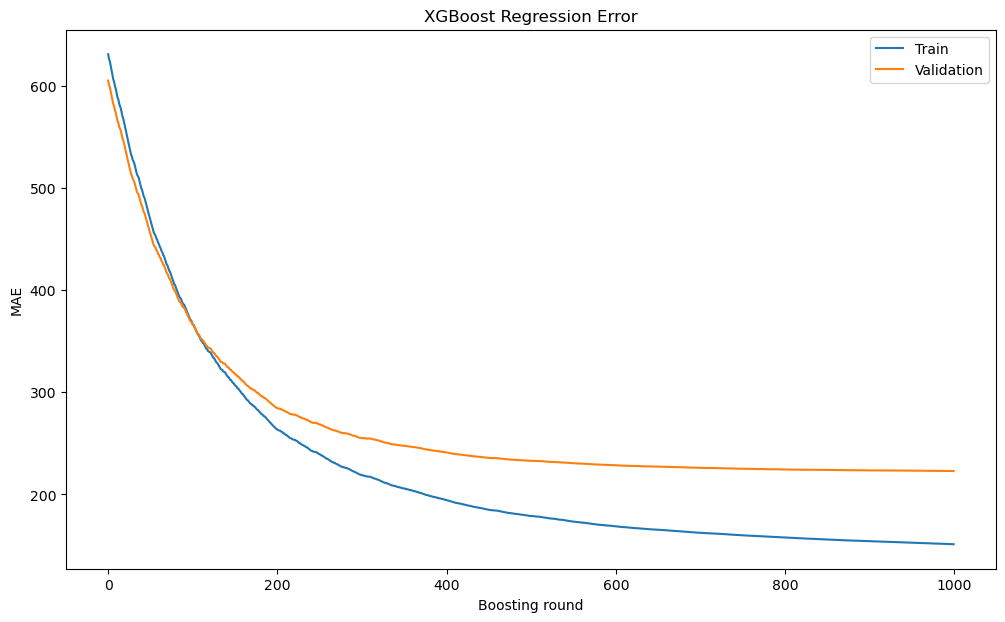

In [43]:
evals_result_A = model_A.evals_result()
evals_result_B = model_B.evals_result()
evals_result_C = model_C.evals_result()

train_error_A = evals_result_A['validation_0']['mae']
val_error_A = evals_result_A['validation_1']['mae']
train_error_B = evals_result_B['validation_0']['mae']
val_error_B = evals_result_B['validation_1']['mae']
train_error_C = evals_result_C['validation_0']['mae']
val_error_C = evals_result_C['validation_1']['mae']

epochs = len(train_error_A)
x_axis = range(0, epochs)

# Plot for model A
plt.figure(figsize=(12, 7))
plt.plot(x_axis, train_error_A, label='Train')
plt.plot(x_axis, val_error_A, label='Validation')
plt.legend()

plt.ylabel('MAE')
plt.xlabel('Boosting round')
plt.title('XGBoost Regression Error')
plt.show()


# Features in the best prediction 154 MAE

0 total_radiation: 0.4234558045864105 \
1 direct_rad:W: 0.2128763496875763 \
2 direct_rad_1h:J: 0.0615650974214077 \
3 total_radiation_rolling_avg_3: 0.03578149154782295 \
4 diffuse_rad:W: 0.02013232931494713 \
5 clear_sky_rad:W: 0.013245003297924995 \
6 snow_accumulation: 0.012912849895656109 \
7 sun_azimuth:d_lag_7: 0.010069170035421848 \
8 sun_elevation:d: 0.009076440706849098 \
9 relative_humidity_1000hPa:p_lag_-3: 0.006535227410495281 \
10 sun_azimuth:d: 0.005778656806796789 \
11 diffuse_rad_1h:J: 0.00557068781927228 \
12 temp_dewpoint_diff_lag_-4: 0.0054164547473192215 \
13 clear_sky_rad:W_rate_of_change: 0.005305740050971508 \
14 effective_cloud_cover:p: 0.005097666289657354 \
15 hour: 0.005087343044579029 \
16 date_forecast_fft_amplitude: 0.004949505440890789 \
17 clear_sky_energy_1h:J: 0.004622776992619038 \
18 msl_pressure:hPa_lag_3: 0.004557096865028143 \
19 t_1000hPa:K_rolling_avg_24: 0.004549496807157993 \
20 total_cloud_cover:p: 0.004411020781844854 \
21 visibility:m_lag_-2: 0.00400067213922739 \
22 total_radiation_rate_of_change: 0.003874964313581586 \
23 month: 0.0038293872494250536 \
24 sfc_pressure:hPa: 0.0038288664072752 \
25 average_wind_speed: 0.0038149317260831594 \
26 t_1000hPa:K_lag_4: 0.003787972265854478 \
27 sun_elevation:d_fft_phase: 0.0037678431253880262 \
28 pressure_50m:hPa: 0.0037581848446279764 \
29 msl_pressure:hPa_rolling_avg_24: 0.00369848869740963 \
30 dew_point_2m:K_lag_19: 0.0035477483179420233 \
31 t_1000hPa:K: 0.0035387056414037943 \
32 pressure_100m:hPa: 0.003512951312586665 \
33 total_cloud_cover:p_rolling_avg_6: 0.003464051755145192 \
34 direct_rad:W_rate_of_change: 0.003448427189141512 \
35 dew_point_2m:K: 0.003425233531743288 \
36 absolute_humidity_2m:gm3_rolling_avg_24: 0.003379648318514228 \
37 pressure_gradient: 0.0033784068655222654 \
38 sfc_pressure:hPa_lag_8: 0.003355256747454405 \
39 sun_elevation:d_fft_amplitude: 0.0033312165178358555 \
40 year: 0.003244817489758134 \
41 wind_vector_magnitude: 0.003148019313812256 \
42 date_forecast_fft_phase: 0.003074726788327098 \
43 absolute_humidity_2m:gm3: 0.003025446319952607 \
44 msl_pressure:hPa: 0.003022641409188509 \
45 t_1000hPa:K_rate_of_change: 0.003010170767083764 \
46 effective_cloud_cover:p_rate_of_change: 0.0029358689207583666 \
47 clear_sky_rad:W_rate_of_change_of_change: 0.002842330140992999 \
48 effective_cloud_cover:p_rolling_avg_6: 0.002791582839563489 \
49 clear_sky_rad:W_rolling_avg_6: 0.002718282165005803 \
50 total_cloud_cover:p_rate_of_change: 0.0026860570069402456 \
51 observed: 0.0026119498070329428 \
52 wind_vector_magnitude_lag_8: 0.002609953982755542 \
53 temp_dewpoint_diff: 0.002551795681938529 \
54 total_radiation_rate_of_change_of_change: 0.0025030174292623997 \
55 direct_rad:W_rate_of_change_of_change: 0.00249316799454391 \
56 relative_humidity_1000hPa:p: 0.00249219941906631 \
57 total_cloud_cover:p_rate_of_change_of_change: 0.002429977525025606 \
58 diffuse_rad:W_rate_of_change: 0.0024279451463371515 \
59 sun_elevation:d_rolling_avg_6: 0.0023145817685872316 \
60 visibility:m: 0.002289965283125639 \
61 dew_point_2m:K_rate_of_change: 0.0022229659371078014 \
62 dew_point_2m:K_rate_of_change_of_change: 0.002219223417341709 \
63 effective_cloud_cover:p_rate_of_change_of_change: 0.002212965628132224 \
64 dew_or_rime:idx_lag_11: 0.0021920606959611177 \
65 t_1000hPa:K_rate_of_change_of_change: 0.0020750060211867094 \
66 diffuse_rad:W_rate_of_change_of_change: 0.0020208051428198814 \
67 is_in_shadow:idx: 7.590975292259827e-05 \
68 is_day:idx: 1.739487561280839e-05 \
69 prob_rime:p: 0.0 \